## 📘 Notebook 02: Data Acquisition & Exploration

---

### **Introduction**
In this notebook, we will prepare TCGA-BRCA RNA-Seq data for use in a machine learning pipeline.  
The main steps include:

- Loading gene expression data from the UCSC Xena Browser
- Inspecting and reshaping
- Merging with PAM50 molecular subtype labels
- Preprocessing 
- Initial exploration 

The resulting dataset will be used for explainable subtype classification models in future notebooks.

---

### 1. **Setup**
We start by importing the necessary Python packages for data loading, preprocessing, and basic inspection:




In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# File handling and OS utilities
import os

Package overview:

- pandas: For loading and handling tabular gene expression and subtype data

- numpy: For numerical operations and matrix handling

- os: For file path management and saving results

---

### 2. **Data Acquisition**

To train our subtype classification model, we need two complementary data sources:

1. **Gene expression data** — RNA-Seq expression values across breast cancer samples  
2. **Subtype labels** — PAM50 molecular subtype annotations for those samples

In this section, we will obtain both:

- The **gene expression matrix** will be loaded from the UCSC Xena data hub (FPKM-normalized RNA-seq data)
- The **PAM50 subtype labels** will be acquired using R and the `TCGAbiolinksGUI.data` package

We will then preprocess and align both datasets for use in downstream machine learning tasks.

### 2.1 Gene Expression Data (via pandas)

We will load the needed gene expression data, directly from the UCSC Xena hub into Python using `pandas`.  

In a next step, we will download the gene expression dataset locally. This is not strictly necessary, as the data can be loaded directly from the UCSC Xena hub.  
However, we choose to keep a local copy for consistency, since the PAM50 subtype labels will also be obtained via a local export.  
This ensures our entire data pipeline is self-contained and reproducible.

In [4]:
# URL of the TCGA-BRCA FPKM dataset hosted by UCSC Xena
url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-BRCA.star_fpkm.tsv.gz"

# Load dataset directly (pandas handles the gzip automatically)
df_expr = pd.read_csv(url, sep="\t", index_col=0)

# Optional: Save locally to keep data pipeline consistent
# df_expr.to_csv("../data/TCGA-BRCA_FPKM.tsv", sep="\t")

### 2.2 PAM50 Subtype Labels (via R)

Since PAM50 molecular subtype annotations are not included in the gene expression dataset from Xena, we obtain them using R and the `TCGAbiolinksGUI.data` package.  

These subtype labels classify breast tumors into 5 intrinsic types:  
**Luminal A**, **Luminal B**, **Basal-like**, **HER2-enriched**, and **Normal-like**.  

We run the following R code(in RStudio) to download and export the labels to CSV:

```r
# Install necessary packages
if (!requireNamespace("TCGAbiolinks", quietly = TRUE)) {
  install.packages("BiocManager")
  BiocManager::install("TCGAbiolinks")
}
if (!requireNamespace("TCGAbiolinksGUI.data", quietly = TRUE)) {
  BiocManager::install("TCGAbiolinksGUI.data")
}

# Load libraries
library(TCGAbiolinks)
library(TCGAbiolinksGUI.data)

# Load subtype data for all TCGA cancers
data("subtypes")

# Filter for BRCA samples and select relevant columns
df_brca <- subset(subtypes, cancer.type == "BRCA")
df_brca <- df_brca[, c("pan.samplesID", "Subtype_Selected")]
colnames(df_brca) <- c("Sample", "Subtype")

# Export to CSV for use in Python
write.csv(df_brca, "data/PAM50_BRCA.csv", row.names = FALSE)

```
After doing that we have a correct file 'PAM50_BRCA.csv' we can use to match to the Gene Expression data we acquired in the last step. 

---

### 3. **Initial Data Inspection & Reshaping**
Now that we’ve acquired both datasets, let’s inspect them before moving on to any processing.  

### 3.1 Inspection
We’ll start with the gene expression data to understand its structure and format

In [5]:
print(df_expr.head())
print(df_expr.shape)

                    TCGA-D8-A146-01A  TCGA-AQ-A0Y5-01A  TCGA-C8-A274-01A  \
Ensembl_ID                                                                 
ENSG00000000003.15          3.816190          2.034638          4.823000   
ENSG00000000005.6           1.796473          0.134221          0.000000   
ENSG00000000419.13          4.971102          5.159173          5.107052   
ENSG00000000457.14          2.656428          2.324868          3.407869   
ENSG00000000460.17          1.395556          1.088888          2.505002   

                    TCGA-BH-A0BD-01A  TCGA-B6-A1KC-01B  TCGA-AC-A62V-01A  \
Ensembl_ID                                                                 
ENSG00000000003.15          3.028003          2.865503          2.122341   
ENSG00000000005.6           1.058801          0.166972          0.275722   
ENSG00000000419.13          4.595068          4.693615          5.189662   
ENSG00000000457.14          2.659925          2.249506          1.033723   
ENSG0000000

As we can see the gene expression dataset is structured as a matrix with genes as rows (indexed by Ensembl IDs) and samples as columns (TCGA barcodes).

Each cell contains a `log₂(FPKM + 1)` **normalized expression value**.  
The sample IDs are already trimmed to 16 characters, ending after the sample type (e.g., 01A).

Now let's take a look at the complementary **PAM50 subtype dataset**:

In [6]:
# Load PAM50 subtype labels
df_labels = pd.read_csv("../data/PAM50_BRCA.csv")

# Show the first few rows
print(df_labels.head())

                         Sample      Subtype
0  TCGA-E2-A158-11A-22R-A12D-07  BRCA.Normal
1  TCGA-BH-A0DD-11A-23R-A12P-07    BRCA.LumA
2  TCGA-BH-A1EO-11A-31R-A137-07    BRCA.LumA
3  TCGA-BH-A0B5-11A-23R-A12P-07    BRCA.LumA
4  TCGA-A7-A13G-11A-51R-A13Q-07    BRCA.LumA


As we can see, the sample IDs in the subtype label dataset use the **full TCGA barcode**, while the gene expression dataset uses only the first 16 characters.

However, for matching subtype labels to expression data, the **first 15 characters** of the TCGA barcode are sufficient to uniquely identify each sample.

A typical TCGA Barcode could look like this: TCGA-XX-YYYY-01A-11D-A13B-09 
- TCGA - Project name
- XX - Tissue source site (e.g., the hospital that collected the sample) 
- YYYY - Patient ID
- 01A - Sample Type and vial (e.g., primary tumor = 01, vial = A)
- 11D - Portion and analyte code
- A13B - Plate ID
- 09 - Center that processed the sample

As we can see the first 15 characters(`TCGA-XX-YYYY-01`) contain the Sample ID and the rest is not really important to uniquely indentify each sample. The rest encodes additional technical metadata, which is usually not necessary for high-level analyses. 

### 3.2 Reshaping

In a next step we will therefore trim all sample IDs to 15 characters to ensure consistency across both datasets before merging.

In [7]:
# Trim sample ID's to first 15 characters in the PAM50 subtype data
df_labels["Sample"] = df_labels["Sample"].str[:15]

In [8]:
# Trim sample IDs to first 15 characters in the gene expression data
df_expr.columns = [col[:15] for col in df_expr.columns]

In [9]:
# Take another look at the reshaped subtype data
print(df_labels.head())

            Sample      Subtype
0  TCGA-E2-A158-11  BRCA.Normal
1  TCGA-BH-A0DD-11    BRCA.LumA
2  TCGA-BH-A1EO-11    BRCA.LumA
3  TCGA-BH-A0B5-11    BRCA.LumA
4  TCGA-A7-A13G-11    BRCA.LumA


In [10]:
# Take another look at the reshaped gene expression data
print(df_expr.iloc[:5, :3])

                    TCGA-D8-A146-01  TCGA-AQ-A0Y5-01  TCGA-C8-A274-01
Ensembl_ID                                                           
ENSG00000000003.15         3.816190         2.034638         4.823000
ENSG00000000005.6          1.796473         0.134221         0.000000
ENSG00000000419.13         4.971102         5.159173         5.107052
ENSG00000000457.14         2.656428         2.324868         3.407869
ENSG00000000460.17         1.395556         1.088888         2.505002


### 3.3 Transposing

We can see that in the gene expression dataset the sample ID's are column names, while in the subtype dataset they are rows.  
Before we can merge the two datasets on their sample ID, we need the sample ID to be rows in both datasets. 
To manage that, all we have to do is transpose the expression matrix, flipping it, so every row becomes a sample, and each column a gene.  


In [11]:
# Transpose expression data
df_expr_T = df_expr.T

df_expr_T.index.name = "Sample" # set index name for merge

# We also reset index on expression data to expose sample IDs as a column
df_expr_T = df_expr_T.reset_index()  # 'Sample' will now be a column instead of the index

df_expr_T.columns.name = None

# Take another look at the transposed expression dataset
print(df_expr_T.iloc[:5, :3])

            Sample  ENSG00000000003.15  ENSG00000000005.6
0  TCGA-D8-A146-01            3.816190           1.796473
1  TCGA-AQ-A0Y5-01            2.034638           0.134221
2  TCGA-C8-A274-01            4.823000           0.000000
3  TCGA-BH-A0BD-01            3.028003           1.058801
4  TCGA-B6-A1KC-01            2.865503           0.166972


As we can see, both datasets are now aligned by sample ID and ready for merging in the next step.


---

### 4. **Merge Gene Expression Data with Labels**

Now that we have prepared both datasets, merging them becomes quite simple. 


In [12]:
# Merging the datasets
df_merged = pd.merge(df_expr_T, df_labels, on="Sample")

# Optional: set 'Sample' back as index 
df_merged = df_merged.set_index("Sample")

# Move 'Subtype' to the first column to improve readability
cols = df_merged.columns.tolist()
cols.insert(0, cols.pop(cols.index("Subtype")))
df_merged = df_merged[cols]

# Preview
print(df_merged.shape)
print(df_merged.head())

(1226, 60661)
                   Subtype  ENSG00000000003.15  ENSG00000000005.6  \
Sample                                                              
TCGA-D8-A146-01  BRCA.LumA            3.816190           1.796473   
TCGA-AQ-A0Y5-01  BRCA.LumA            2.034638           0.134221   
TCGA-C8-A274-01  BRCA.LumB            4.823000           0.000000   
TCGA-BH-A0BD-01  BRCA.LumB            3.028003           1.058801   
TCGA-B6-A1KC-01  BRCA.LumB            2.865503           0.166972   

                 ENSG00000000419.13  ENSG00000000457.14  ENSG00000000460.17  \
Sample                                                                        
TCGA-D8-A146-01            4.971102            2.656428            1.395556   
TCGA-AQ-A0Y5-01            5.159173            2.324868            1.088888   
TCGA-C8-A274-01            5.107052            3.407869            2.505002   
TCGA-BH-A0BD-01            4.595068            2.659925            2.473917   
TCGA-B6-A1KC-01            4

We now have a correctly merged dataset, containing subtype and gene expression for each sample. 

---

### 5. **Preprocessing**

There are still a few things we want to optimize about our dataset. 


### 5.1 Noise Reduction
As part of preprocessing, we aim to reduce noise in the dataset by removing samples that are not relevant for our modeling task.

In Notebook 00, we mentioned that there are four main molecular subtypes, normally categorized. Namely Luminal A, Luminal B, HER2-positive and Basal-like(TNBC). These are also the ones we want our ML-Model to be able to detect. 

But upon further inspection, we notice that the merged dataset also contains samples labeled "normal-like". (142 samples)



In [13]:
# Count how many samples are in each subtype before filtering
print(df_merged["Subtype"].value_counts())


Subtype
BRCA.LumA      587
BRCA.LumB      219
BRCA.Basal     196
BRCA.Normal    142
BRCA.Her2       82
Name: count, dtype: int64


The normal-like subtype exhibits gene expression patterns resembling those of healthy breast tissue, but its significance remains limited due to the likelihood of representing normal cell contamination rather than a distinct tumor biology—which is why it is not widely recognized in clinical practice and is often debated in the literature as to whether it constitutes a true molecular subtype. [[10,11]](#references)

That's why we will remove samples labeled normal-like to focus on the 4 main subtypes and reduce noise:

In [14]:
# Keep only main 4 PAM50 subtypes
main_subtypes = ["BRCA.LumA", "BRCA.LumB", "BRCA.Her2", "BRCA.Basal"]
df_filtered = df_merged[df_merged["Subtype"].isin(main_subtypes)]

In [15]:
# Confirm new distribution
print(df_filtered["Subtype"].value_counts())

Subtype
BRCA.LumA     587
BRCA.LumB     219
BRCA.Basal    196
BRCA.Her2      82
Name: count, dtype: int64


### 5.2 Encode Labels 
To efficiently train a machine learning model, we need to convert categorical subtype labels into numeric values.

We'll assign an integer to each of the four main subtypes:
| Subtype    | Encoded Label |
| ---------- | ------------- |
| BRCA.LumA  | 0             |
| BRCA.LumB  | 1             |
| BRCA.Her2  | 2             |
| BRCA.Basal | 3             |

Here's how we do that in code:

In [16]:
# Filter and copy to avoid SettingWithCopyWarning
df_filtered = df_merged[df_merged["Subtype"] != "BRCA.Normal"].copy()

# Define mapping
label_mapping = {
    "BRCA.LumA": 0,
    "BRCA.LumB": 1,
    "BRCA.Her2": 2,
    "BRCA.Basal": 3
}

# Apply mapping 
df_filtered["Label"] = df_filtered["Subtype"].map(label_mapping)

# Preview unique subtype-label pairs
print(df_filtered[["Subtype", "Label"]].drop_duplicates())


                    Subtype  Label
Sample                            
TCGA-D8-A146-01   BRCA.LumA      0
TCGA-C8-A274-01   BRCA.LumB      1
TCGA-A2-A0YM-01  BRCA.Basal      3
TCGA-E2-A1LE-01   BRCA.Her2      2


### 5.3 Feature Filtering

One problem with our dataset is that its still way too big. We have over 60,000 gene expression features, which is far too many for most machine learning models to handle well.Especially since our data is highly disproportionate: we have a very large number of features (~60,000) compared to relatively few samples (~1,000), which can cause issues such as overfitting and the curse of dimensionality. To address this problem, we therefore need to drastically reduce the number of features (genes) in our matrix. The good thing is that **many genes in RNA-Seq data show very little variation across samples**.  
That means these genes are uninformative for classification and only add noise and computational cost.  

We fix that by removing genes(features) with low variance across samples.

To do that, we first need further inspection to compute how much variance there is for every gene between samples, to determine  
what we count as 'low variance':

In [17]:
# Exclude label columns
X = df_filtered.drop(columns=["Subtype", "Label"])
        
# Compute variance for each gene (column)
gene_variances = X.var(axis=0)

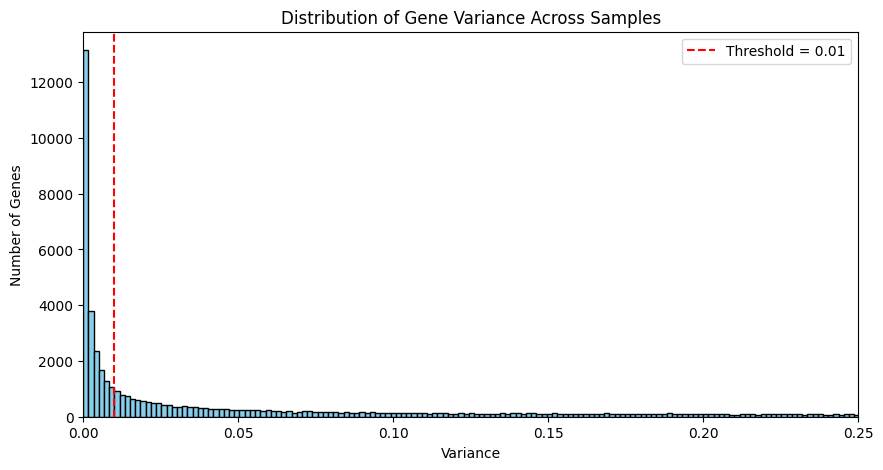

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(gene_variances, bins=10000, color="skyblue", edgecolor="black")
plt.title("Distribution of Gene Variance Across Samples")
plt.xlabel("Variance")
plt.ylabel("Number of Genes")

plt.axvline(x=0.01, color='red', linestyle='--', label='Threshold = 0.01')
plt.legend()

plt.xlim(0, 0.25)
plt.show()

As we can see there are a lot of gene expressions with a variance close to 0.   

A threshold of 0.01 is commonly used in bioinformatics to remove genes with near-constant expression.
As seen in the figure above, this threshold eliminates the long tail of genes with very low variance, helping reduce noise without discarding too many informative genes.


Let us take a look at the concrete numbers to help us choose a threshold to filter out. 

In [19]:
total_genes = gene_variances.shape[0]

for threshold in [0.001, 0.005, 0.01, 0.05, 0.1]:
    count = (gene_variances < threshold).sum()
    percent = (count / total_genes) * 100
    print(f"Genes with variance < {threshold:.3f}: {count} ({percent:.1f}%)")

Genes with variance < 0.001: 10451 (17.2%)
Genes with variance < 0.005: 19254 (31.7%)
Genes with variance < 0.010: 23247 (38.3%)
Genes with variance < 0.050: 33799 (55.7%)
Genes with variance < 0.100: 39094 (64.4%)


As we can see choosing a rather low treshold of 0.01 (which is also standard in bioinformatic research), we already filter out more than 38% of the gene expression features. And therefore lower the workload for our machine learning model drastically, removing a lot of noise.

Let us now remove the genes with lower variance than 0.01 across samples:

In [20]:
from sklearn.feature_selection import VarianceThreshold

# Set the threshold
selector = VarianceThreshold(threshold=0.01)

# Apply to gene expression part (exclude label column)
X = df_filtered.drop(columns=["Subtype", "Label"])
X_filtered = selector.fit_transform(X)

# Keep sample names and labels
df_filtered_genes = pd.DataFrame(X_filtered, index=df_filtered.index, columns=X.columns[selector.get_support()])
df_filtered_genes["Label"] = df_filtered["Label"]

# Preview new gene numbers
print(df_filtered_genes.shape)

(1084, 37404)


As you can see we reduced the number of genes from **60,483** to **37,404** *(~62%)*.  

Now that we’ve removed near-constant genes, the remaining features are more informative and ready for exploratory analysis.

In [46]:
# Count total number of NAs in the dataset
na_count = df_filtered.isna().sum().sum()
print(f"Total number of NA values in the dataset: {na_count}")


Total number of NA values in the dataset: 0


As no missing values were detected, no further NA handling is required.  

### 5.4 Advanced Feature Filtering

After the initial variance-based filtering, we have successfully reduced the number of genes by about 38%.  
However, the dataset still contains far more features than samples, which poses a risk of overfitting and problems related to the curse of dimensionality.  

For most machine learning models, it is preferable to have a feature count smaller than the number of samples, ideally in the range of **50–500 informative genes**.  
To achieve this, we will apply advanced feature filtering techniques such as:  

- **Variance ranking**: selecting the top N genes with the highest variance across samples.  
- **Model-based feature importance**: using algorithms like Random Forest or LASSO to identify the most informative genes.  
- **Statistical testing** (if labels are available): selecting genes that show significant differences across classes (e.g., ANOVA, t-tests).  

This step ensures that we retain the most biologically and statistically informative genes while reducing dimensionality to a level suitable for robust machine learning.



---

### 6. **Exploratory Data Analysis**

Before training any machine learning model, it's crucial to build a solid understanding of the dataset.
EDA helps us assess the quality, structure, and patterns in the data to guide modeling decisions.

It allows us to:

- **Understand the dataset structure and content**

- **Check class balance across molecular subtypes**

- **Visualize gene expression patterns within and across groups**

- **Assess dimensionality for potential reduction**

- **Detect outliers or inconsistencies**

### 6.1 Balance check

Our first step is to inspect the balance between the four molecular subtypes.
This will help us identify any class imbalance that may bias the model or require correction.

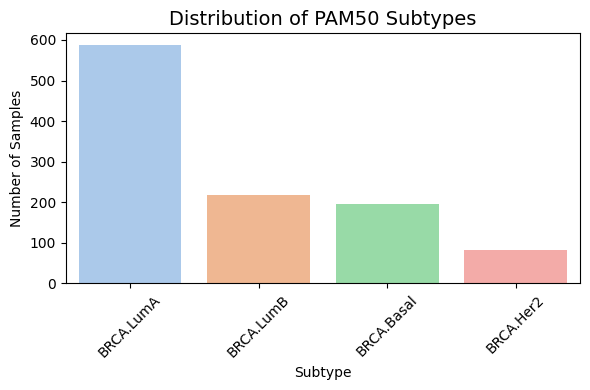

   Subtype  Count  Percentage
 BRCA.LumA    587       54.15
 BRCA.LumB    219       20.20
BRCA.Basal    196       18.08
 BRCA.Her2     82        7.56


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count subtype occurrences
subtype_counts = df_filtered["Subtype"].value_counts().reset_index()
subtype_counts.columns = ["Subtype", "Count"]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=subtype_counts, x="Subtype", y="Count", hue="Subtype", palette="pastel", legend=False)

# Titles and labels
plt.title("Distribution of PAM50 Subtypes", fontsize=14)
plt.xlabel("Subtype")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Count and percentage of each subtype
subtype_summary = df_filtered["Subtype"].value_counts().reset_index()
subtype_summary.columns = ["Subtype", "Count"]
subtype_summary["Percentage"] = 100 * subtype_summary["Count"] / subtype_summary["Count"].sum()
subtype_summary["Percentage"] = subtype_summary["Percentage"].round(2)

# Display summary table
print(subtype_summary.to_string(index=False))


We observe a class imbalance in the dataset: with **Luminal A** being the most common subtype, and **HER2-enriched** the least represented.
This imbalance, however, partially **reflects real-world distributions** of breast cancer molecular subtypes and is expected based on clinical prevalence.

While this means we **do not need to artificially balance** the data, we still need to:

- **Be aware of the imbalance** during model training.

- **Use appropriate evaluation metrics** (e.g., precision, recall, F1-score) instead of relying solely on accuracy.

- **Consider class weighting** or resampling **only if the model severely underperforms on minority subtypes**.

### 6.2 Descriptive Statistics & Visualizations


### 6.3 Heatmap of Gene Expression/ Correlations/ Outlier Detection

To visualize broad patterns in gene expression, we use a heatmap of the 100 most variable genes.

To make it easier to interpret:
- Samples are grouped by their molecular subtype
- Subtypes are color-coded
- Only genes are clustered

This layout highlights whether distinct expression signatures can be observed across subtypes.



c:\Users\ajeng\dev\TumorXAI\tumorxai-env\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


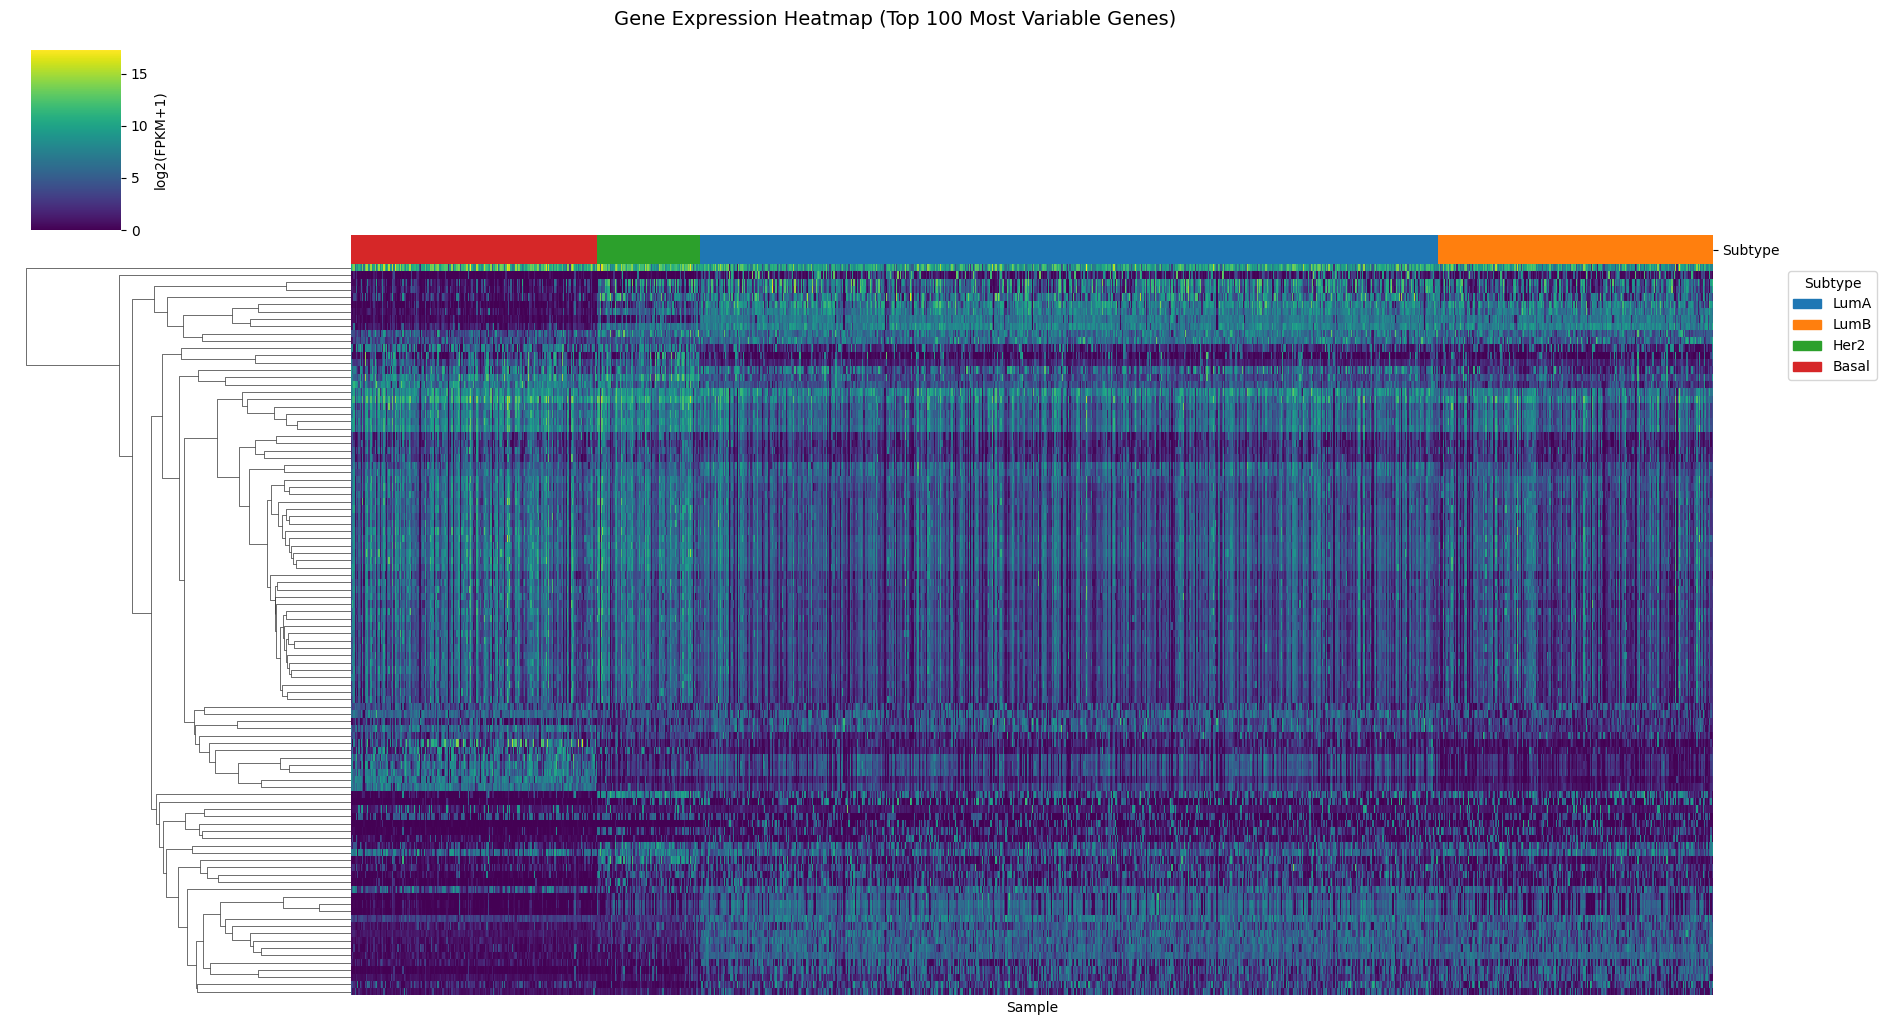

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Reuse top variable genes
top_genes = gene_variances.sort_values(ascending=False).head(100).index
df_top = df_filtered[top_genes].copy()

# Add subtype info and sort
df_top["Subtype"] = df_filtered["Subtype"]
df_top = df_top.sort_values("Subtype")
subtypes = df_top["Subtype"]
df_top = df_top.drop("Subtype", axis=1)

# Define color map for subtypes
subtype_palette = {
    "BRCA.LumA": "#1f77b4",
    "BRCA.LumB": "#ff7f0e",
    "BRCA.Her2": "#2ca02c",
    "BRCA.Basal": "#d62728"
}
row_colors = subtypes.map(subtype_palette)

# Plot clustered heatmap (cluster genes, not samples)
g = sns.clustermap(
    df_top.T,
    row_cluster=True,
    col_cluster=False,
    col_colors=row_colors,
    cmap="viridis",
    yticklabels=False,
    xticklabels=False,
    figsize=(18, 10),
    cbar_kws={"label": "log2(FPKM+1)"}
)

# Create legend patches
handles = [
    mpatches.Patch(color=color, label=label.replace("BRCA.", ""))
    for label, color in subtype_palette.items()
]

# Position legend next to the clustermap figure
g.ax_heatmap.legend(
    handles=handles,
    title="Subtype",
    loc="upper left",         
    bbox_to_anchor=(1.05, 1),  
    frameon=True
)

plt.suptitle("Gene Expression Heatmap (Top 100 Most Variable Genes)", y=1.02, fontsize=14)
plt.show()


The heatmap visualizes the expression values of the top 100 most variable genes across the samples.
On the left side, a dendrogram groups genes by similarity in expression profiles, revealing potential patterns or gene clusters. As we can see there are a lot of genes that show more -or less- expression for certain subtypes. This is important, because that's what our ML model will use to differentiate in the next step.

### 7. Dimension Reduction & Clustering

### 7.1 PCA








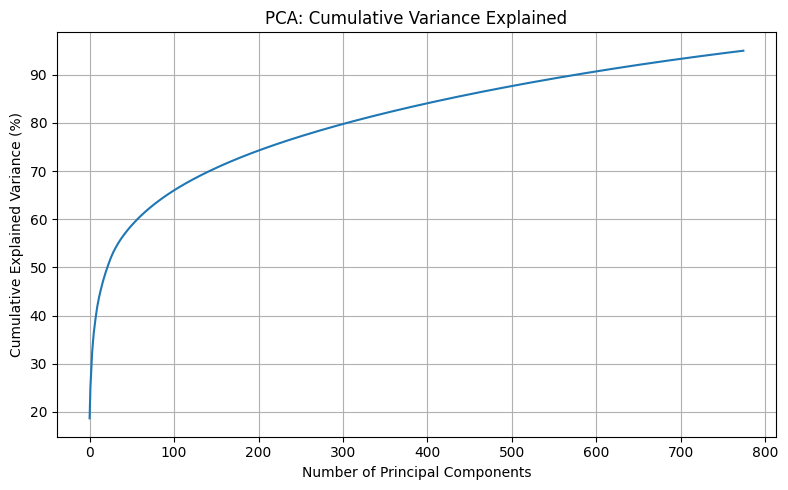

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data: remove label column and standardize features
X = df_filtered.drop(columns=["Subtype", "Label"])
X_scaled = StandardScaler().fit_transform(X)

# Run PCA
pca = PCA(n_components=0.95)  # Try with first 100 components
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA: Cumulative Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()


### 7.2 Clustering

### 7.3 Cluster Evaluation & Metrics

--- 

### 8. Export

### 8.1 Save Processed 

### 8.2 Save Cluster Results/ Moel


---

### 9. Summary / Next Steps